<a href="https://colab.research.google.com/github/rachida0001/Chest-Xray-Pneumonia-Detection/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libs

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image
import cv2

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from seaborn import heatmap

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

#from google.colab.patches import cv2_imshow

# Read and normalize images

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip

In [20]:
NORMAL_images_train = os.listdir('/content/chest_xray/train/NORMAL')
PNEUMONIA_images_train = os.listdir('/content/chest_xray/train/PNEUMONIA')

NORMAL_images_test = os.listdir('/content/chest_xray/test/NORMAL')
PNEUMONIA_images_test = os.listdir('/content/chest_xray/test/PNEUMONIA')

NORMAL_images_val = os.listdir('/content/chest_xray/val/NORMAL')
PNEUMONIA_images_val = os.listdir('/content/chest_xray/val/PNEUMONIA')

In [5]:
INPUT_SHAPE = (128,128,1)
new_width = 128
new_height = 128

In [9]:
def resize_grayscale_desired_dimensions(img, new_width, new_height):
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img

def normlizing_image(img, new_width, new_height):
    resized_img = resize_grayscale_desired_dimensions(img, new_width, new_width)
    return resized_img/255

def reading_image(listdir_name, path):
  images_array = []
  for img_file in listdir_name:
    if img_file[-4:] == 'jpeg':
      img_array = cv2.imread(f'{path}/{img_file}', 0)
      resized_img = resize_grayscale_desired_dimensions(img_array, new_width, new_width)
      resized_img = normlizing_image(img_array, new_width, new_width)
      images_array.append(resized_img)
  return images_array

In [21]:
normal_images_array = reading_image(NORMAL_images_train, '/content/chest_xray/train/NORMAL')
pneumonia_images_array = reading_image(PNEUMONIA_images_train, '/content/chest_xray/train/PNEUMONIA')

normal_images_test_array = reading_image(NORMAL_images_test, '/content/chest_xray/test/NORMAL')
pneumonia_images_test_array = reading_image(PNEUMONIA_images_test, '/content/chest_xray/test/PNEUMONIA')

normal_images_val_array = reading_image(NORMAL_images_val, '/content/chest_xray/val/NORMAL')
pneumonia_images_val_array = reading_image(PNEUMONIA_images_val, '/content/chest_xray/val/PNEUMONIA')

In [22]:
x_train = np.array(normal_images_array + pneumonia_images_array)
y_train = np.array([0]*len(normal_images_array) + [1]*len(pneumonia_images_array))

shuffled_indices = np.random.permutation(len(x_train))
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_test = np.array(normal_images_test_array + pneumonia_images_test_array)
y_test = np.array([0]*len(normal_images_test_array) + [1]*len(pneumonia_images_test_array))

shuffled_indices = np.random.permutation(len(x_test))
x_test = x_test[shuffled_indices]
y_test = y_test[shuffled_indices]

x_val = np.array(normal_images_val_array + pneumonia_images_val_array)
y_val = np.array([0]*len(normal_images_val_array) + [1]*len(pneumonia_images_val_array))

shuffled_indices = np.random.permutation(len(x_val))
x_val = x_val[shuffled_indices]
y_val = y_val[shuffled_indices]

# Visualisation

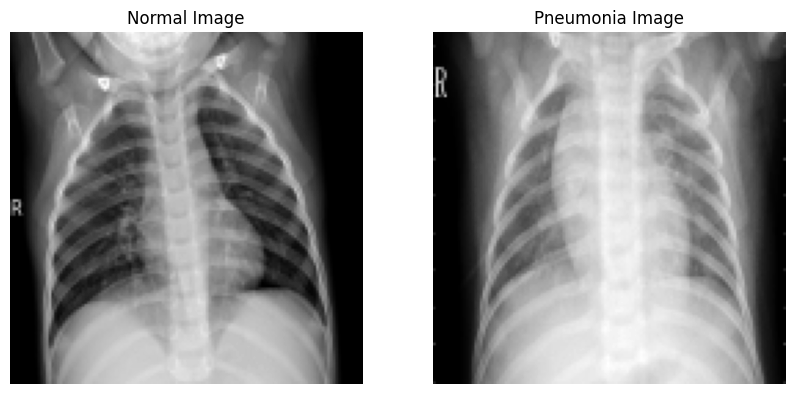

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(normal_images_array[8], cmap='gray')
plt.title('Normal Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_images_array[8], cmap='gray')
plt.title('Pneumonia Image')
plt.axis('off')

plt.show()

# Image Augmentation

In [23]:
x_train = x_train.reshape(x_train.shape[0], 128, 128, 1)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 1)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)
datagen.fit(x_test)

# Build the model

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 62, 62, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        3

# Train the model

In [24]:
# Train the model
model.fit(datagen.flow(x_train, y_train, batch_size=32),
          epochs=50,
          validation_data=(x_val, y_val),
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
163/163 [==============================] - 533s 3s/step - loss: 3.5185 - accuracy: 0.7747 - val_loss: 6.1580 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 520s 3s/step - loss: 1.9652 - accuracy: 0.8271 - val_loss: 12.8402 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 525s 3s/step - loss: 1.1730 - accuracy: 0.8514 - val_loss: 11.4969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 528s 3s/step - loss: 0.7949 - accuracy: 0.8643 - val_loss: 2.7960 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 517s 3s/step - loss: 0.6393 - accuracy: 0.8817 - val_loss: 6.0375 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 509s 3s/step - loss: 0.5680 - accuracy: 0.8898 - val_loss: 3.5583 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
163/163 [==============================] - 518s 3s/



# Test the model



In [32]:
pred_y = model.predict(x_test)

for i in range(len(pred_y)):
  if pred_y[i] >= 0.5:
    pred_y[i] = 1
  else:
    pred_y[i] = 0

pred_y = pred_y.astype(int)

20/20 [==============================] - 16s 799ms/step


In [37]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

20/20 [==============================] - 16s 778ms/step - loss: 0.3990 - accuracy: 0.8830
Loss: 0.3989703059196472, Accuracy: 0.8830128312110901


In [35]:
accuracy = accuracy_score(y_test, pred_y)
print(f'accuracy : {accuracy}')

f1_score = f1_score(y_test, pred_y)
print(f'f1_score : {f1_score}')

recall_score = recall_score(y_test, pred_y)
print(f'recall_score : {recall_score}')

accuracy : 0.8830128205128205
f1_score : 0.9119420989143547
recall_score : 0.9692307692307692


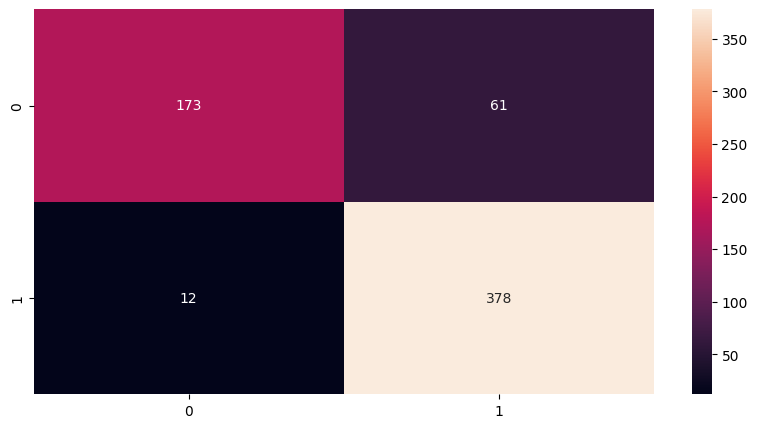

In [36]:
confusion_matrix(y_test, pred_y)

plt.figure(figsize=(10, 5))
heatmap(confusion_matrix(y_test, pred_y), annot=True, fmt='d')
plt.show()